In [1]:
pip install tableone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader 
from tableone import TableOne, load_dataset
np.random.seed(0)
torch.manual_seed(0)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
data = pd.read_excel('/content/HD_2019_M_2.xlsx')
all_nan = data.columns[data.isnull().sum() == 465].tolist()
data = data.drop(columns = all_nan)
trainset= {}

In [5]:
def age(date):
    date = date.split('/')
    age = 111-int(date[0])
    return age
def treat_year(date):
    date = date.split('/')
    year = 2019-int(date[0])
    return year

In [6]:
df = data.rename(columns = {'合併症':'comorbidities', '性別':'gender', '離子鈣 (mg/dl)':'Ca', '生日':'birthday', 
    '透析前體重(kg)':'weight', '本次透析時間(min)':'duration', '本次透析前BUN (mg/dl)':'BUN', '兩次透析時間間隔 (min)':'time_interval'})
df['Age'] = df['birthday'].map(age)
df['treatment_year'] = df['開始治療日期'].map(treat_year)
# 合併症因為還不確定空值所以先暫時刪掉，Glucose因為空值太多所以先刪掉, Kt/V (Gotch)適用另一種公式算的先刪掉
df = df.drop(columns = ['本次透析後BUN (mg/dl)', '透析後體重(kg)', '透析器型號', 'PlanDate', 'birthday', '開始治療日期','Glucose[AC] (mg/dl)','Kt/V (Gotch)']) 


In [7]:
#target_col = [col for col in x.columns if '(' in col]
def trim_column(col,df):
  new_col = col.split(' (')[0]
  df = df.rename(columns = {col:new_col})
  return df
col_list = df.filter(like=' (').columns

for i in col_list:
  df = trim_column(i,df)

In [8]:
df = df[df[df.columns[4:15]].isna().sum(axis=1) == 0] # drop parameter contain null value
df = df[df.isna().sum(axis=1)<10] # 病患特徵中有3個人缺值超過10個欄位，這三個人直接刪掉
df = df.drop(396) # drop kt/v is null

In [9]:
def split_comorbidity(x):
  output = []
  x = x.split('-')
  for i in x:
    if i!='0':
      output.append(int(i))
  #x = [int(i) for i in x]
  return output
df['comorbidities'] = df['comorbidities'].map(split_comorbidity)

In [10]:
table = df.copy()
columns = list(table.columns[1:4])+list(table.columns[5:])
#columns = list(table.columns)
categorical  = ['gender','HBsAg','Anti-HCV','透析方式','抗凝劑','初劑量','維持劑量','每次透析時間','透析器表面積','鈣離子濃度','鉀離子濃度']
mytable = TableOne(table, columns=columns, categorical=categorical) #,categorical=categorical
mytable.to_csv('mytable.csv')

/usr/local/lib/python3.7/dist-packages/tableone/tableone.py:991: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df['percent'] = df['freq'].div(df.freq.sum(level=0),


In [ ]:
# 要補空值的欄位有 W.B.C. (x1000/ul), Platelet (x1000/ul), Cardiac/thoracic ratio (%) 都補mean
df['Cardiac/thoracic ratio'] = df['Cardiac/thoracic ratio'].fillna(round(df['Cardiac/thoracic ratio'].mean(),2))
df['W.B.C.'] = df['W.B.C.'].fillna(round(df['W.B.C.'].mean(),1))
df['Platelet'] = df['Platelet'].fillna(round(df['Platelet'].mean(),0))

In [ ]:
# split x and y
df = df[df['Kt/V']>1.2]
df = df.reset_index(drop = True)  # drop掉每筆都一樣的column
df = df.drop(columns = ['time_interval','duration','鹼基','Kt/V'])
x = df[df.columns[1:5].tolist()+df.columns[20:].tolist()]

In [ ]:
# x
# encoding gender, HBsAg, Anti-HCV
for i in ['HBsAg','Anti-HCV']:
  tempdf = pd.get_dummies(x[i])
  for j in tempdf.columns:
    new_col_name = i+'_'+str(j)
    tempdf = tempdf.rename(columns={j:new_col_name})
  x = pd.concat([x,tempdf],axis=1)
x['gender'] = x['gender'].apply(lambda x:0 if x == 1 else 1)
x = x.drop(columns = ['HBsAg','Anti-HCV'])

# standardize
scaler = StandardScaler().fit(x[x.columns[2:-6]])
x_scaled = scaler.transform(x[x.columns[2:-6]])
x_scaled = pd.DataFrame(data = x_scaled,columns = x.columns[2:-6].tolist())
patient_state = pd.concat([x[x.columns[0]],x[x.columns[-6:]],x_scaled],axis=1)
#patient_state = torch.Tensor(patient_state.to_numpy())


In [ ]:
from sklearn.decomposition import PCA

comorbidity_df = pd.DataFrame(data = np.zeros((223,33),dtype=int),columns = ['c'+str(i+1) for i in range(33)])
comorbidity = x[x.columns[1]]

for index,row in enumerate(comorbidity):
  comorbidity_df.loc[index,['c'+str(i) for i in row]] = 1

pca = PCA(n_components=10)
pca.fit(comorbidity_df)
com_pca = pca.transform(comorbidity_df)
com_pca_df = pd.DataFrame(data = com_pca,columns=['com_pca_'+str(i+1) for i in range(10)])
# concat comorbidity and patient state
#patient_state = pd.concat([x[x.columns[0]],x[x.columns[-6:]],x_scaled,com_pca_df],axis=1)
patient_state = pd.concat([patient_state,com_pca_df],axis=1)
patient_state = torch.Tensor(patient_state.to_numpy())

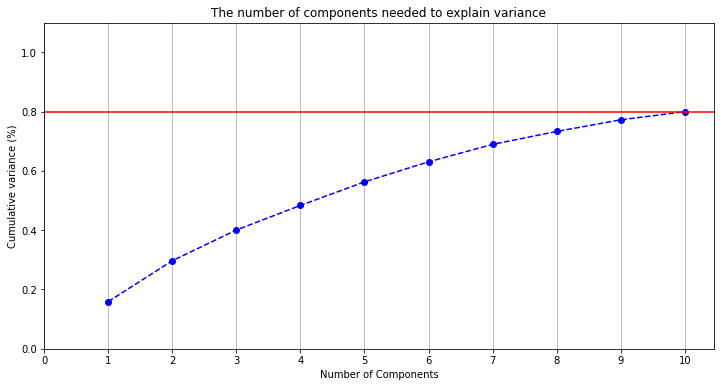

In [ ]:

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 11, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.8, color='r', linestyle='-')
#plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [ ]:
y_dict = {}
y = df[df.columns[5:15].tolist()]
for i in ['透析方式','抗凝劑','鉀離子濃度','維持劑量','初劑量','每次透析時間','透析器表面積','鈣離子濃度']:
  le = preprocessing.LabelEncoder()
  le.fit(y[i])
  temp = { i : v for i ,v in enumerate(list(le.classes_))}
  y_dict[i] = temp
  y[i] = le.transform(y[i])

# y
# 預測的時候 除了血液流速和透析流速之外都當作是類別型來預測，只有血液流速和透析流速 output_dim = 1, 其他output_dim = num_class
parameter = {}
label_name = y.columns
# 暫時先用一個參數當作預測目標
for i in y.columns:
  parameter[i] = torch.Tensor(y[i].to_numpy())
unit_dict = { i : len(y[i].value_counts()) for i in y.columns}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y
        
        
    def __getitem__(self, index):
        self.output = {}
        self.output['patient_state'] = self.x[index]
       
        for i in self.y.keys():
          self.output[i] = self.y[i][index]

        return self.output
    
    def __len__(self):
        return len(self.x)

dataset = MyDataset(patient_state,parameter)
dataloader = DataLoader(dataset, batch_size=4, num_workers=2)
next(iter(dataloader))

{'patient_state': tensor([[ 1.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  0.0000e+00, -3.8166e-01,  2.4859e+00,  2.5522e+00,
           7.2429e-01,  1.3463e-01, -1.5598e+00,  7.3765e-01, -8.9495e-01,
          -3.1283e-02,  4.0742e-01, -3.4826e-01, -7.2731e-01,  2.6678e+00,
           1.4609e+00,  3.0419e-01,  2.7281e-01, -7.8762e-01,  8.4567e-01,
           1.8244e+00, -1.5861e-01, -2.6609e-02, -4.8677e-01,  2.2379e-01,
           6.1707e-02, -3.3614e-01, -5.4707e-01, -9.6112e-02,  3.3610e-03,
          -1.2367e-01],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
           0.0000e+00,  0.0000e+00, -8.7081e-01, -5.0627e-01, -5.8467e-01,
           2.7442e-01, -1.7090e+00, -4.3659e-01,  7.9174e-01, -1.8606e-01,
           9.2000e-01, -3.1826e-01,  1.2068e+00, -8.0793e-01, -1.3023e-02,
           7.8960e-01,  7.6679e-01, -5.2558e-01, -3.8727e-01,  5.2108e-01,
           1.9539e+00, -7.7268e-01, -1.3522e-01,  1.2535e-0

In [ ]:
'''class Embedding(keras.layers.Layer):
  def __init__(self, input_dim, output_dim):
    super(Embedding, self).__init__()
    self.embed_layer = tf.keras.layers.Embedding(input_dim, output_dim)#,input_length=
  
  def call(self, input):
    output = self.embed_layer(input)
    return output'''

In [ ]:
class Net(nn.Module):
  def __init__(self, unit_dict):
    super(Net, self).__init__()
    self.layer1 = nn.Linear(36, 64) 
    self.relu = nn.ReLU()
    self.layer2 = nn.Linear(64, 32)
    self.layer3 = nn.Linear(32, 16)
    self.branch1 = nn.Linear(16, unit_dict['透析方式'])
    self.branch2 = nn.Linear(16, unit_dict['抗凝劑'])
    self.branch3 = nn.Linear(16, unit_dict['初劑量'])
    self.branch4 = nn.Linear(16, unit_dict['維持劑量'])
    self.branch5 = nn.Linear(16, 1)
    self.branch6 = nn.Linear(16, 1)
    self.branch7 = nn.Linear(16, unit_dict['每次透析時間'])
    self.branch8 = nn.Linear(16, unit_dict['透析器表面積'])
    self.branch9 = nn.Linear(16, unit_dict['鈣離子濃度'])
    self.branch10 = nn.Linear(16, unit_dict['鉀離子濃度'])

  def forward(self, x):
    x = self.layer1(x)
    x = self.relu(x)
    x = self.layer2(x)
    x = self.relu(x)
    x = self.layer3(x)
    label1 = self.branch1(x)
    label2 = self.branch2(x)
    label3 = self.branch3(x)
    label4 = self.branch4(x)
    label5 = self.branch5(x)
    label6 = self.branch6(x)
    label7 = self.branch7(x)
    label8 = self.branch8(x)
    label9 = self.branch9(x)
    label10 = self.branch10(x)

    return {'透析方式' : label1, '抗凝劑' : label2, '初劑量' : label3, '維持劑量' : label4, '血液流速' : label5, 
          '透析液流速' : label6, '每次透析時間' : label7, '透析器表面積' : label8, '鈣離子濃度' : label9, '鉀離子濃度' : label10}
    #return {'透析方式' : label1, '抗凝劑' : label2, '初劑量' : label3, '維持劑量' : label4, '血液流速' : label5, '透析液流速' : label6}
model = Net(unit_dict)
#model2 = Net(unit_dict)

In [ ]:
Weightloss1 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
Weightloss2 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
Weightloss3 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
Weightloss4 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
Weightloss5 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
Weightloss6 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
Weightloss7 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
Weightloss8 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
Weightloss9 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)
Weightloss10 = torch.tensor(torch.FloatTensor([1]), requires_grad=True)

params = [Weightloss1, Weightloss2, Weightloss3, Weightloss4, Weightloss5, 
      Weightloss6, Weightloss7, Weightloss8, Weightloss9, Weightloss10]
opt1 = torch.optim.Adam(model.parameters(), lr=0.01)
opt2 = torch.optim.Adam(params, lr=0.01)
loss_func = {'categorical' : nn.CrossEntropyLoss() ,'continuous' : nn.MSELoss()}
Gradloss = nn.L1Loss()
alph = 0.16

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy 

In [ ]:

params_dict = {i : torch.tensor(torch.FloatTensor([1]), requires_grad=True) for i in y.columns}
#
opt1 = torch.optim.Adam(model.parameters(), lr=0.001)
opt2 = torch.optim.Adam(list(params_dict.values()), lr=0.001)
#loss_func = nn.MSELoss()
loss_func = {'categorical' : nn.CrossEntropyLoss() ,'continuous' : nn.MSELoss()}
Gradloss = nn.L1Loss()
alph = 0.16

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
def cretirion(y_true, y_pred, params, loss_func, continuous):
  loss = 0
  if continuous == True:
    loss_value = params*loss_func(y_pred,y_true)
  else:
    loss_value = params*loss_func(y_pred,y_true.squeeze().type(torch.LongTensor))
  return loss_value

In [ ]:
def grand_norm(loss_list, loss0_list, model_param):   #model_param放 list(model.parameters())[4]
    G_list = []
    lhat_list = []
    inv_rate_list = []
    C_list = []
    print('loss_list',loss_list)
    print('loss0_list',loss0_list)
    for i in loss_list:
      GnR = torch.autograd.grad(i, model_param, retain_graph=True, create_graph=True)
      Gn = torch.norm(GnR[0],2)
      G_list.append(Gn)
    G_avg = torch.div(torch.sum(torch.stack(G_list), dim=0), 10)

    for i,j in zip(loss_list,loss0_list):
      lhat_list.append(torch.div(i,j))
    print('lhat_list',lhat_list)
    lhat_avg = torch.div(torch.sum(torch.stack(lhat_list), dim=0), 10)

    for lhatn in lhat_list:
      inv_rate_list.append(torch.div(lhatn,lhat_avg))
    print('lhatn',inv_rate_list)
    for inv_rate in inv_rate_list:
      C = G_avg*(inv_rate)**alph
      C_list.append(C.detach())
    print('Clist',C_list)
    return C_list, G_list

In [ ]:
costtr, cost1tr, cost2tr = [],[],[]
for it in range(10):
    epoch_cost = 0
    epoch_cost1 = 0
    epoch_cost2 = 0
    coef = 0
    
    for index, dataset in enumerate(dataloader):
        loss_list, loss0_list, gradloss_list = [],[],[]
        model.train()
          
        patient_state = dataset['patient_state']
        # zero the parameter gradients
        output=model(patient_state)

        for i in list(dataset.keys())[1:]:
          label = dataset[i]
          label_hat = output[i]
          param = params_dict[i]
          if i == '血液流速' or i == '透析液流速':
            loss_list.append(cretirion(label,label_hat,param,loss_func['continuous'],True))
          else:
            loss_list.append(cretirion(label,label_hat,param,loss_func['categorical'],False))
        #l1 = params[0]*loss_func['categorical'](output['透析方式'], dataset['透析方式'].squeeze().type(torch.LongTensor))    
        #l2 = params[1]*loss_func['continuous'](output['透析液流速'], dataset['透析液流速'])
        loss = torch.div(torch.sum(torch.stack(loss_list), dim=0), 10) 
        
        # for the first epoch with no l0
        if it == 0:
          for i in loss_list:
            loss0_list.append(i.data)
            #l01 = l1.data  
            #l02 = l2.data
        
        opt1.zero_grad()
        
        loss.backward(retain_graph=True)   
        
        G, C = grand_norm(loss_list, loss0_list, list(model.parameters())[4])      
        
        opt2.zero_grad()
        
        for gi,ci in zip(G, C):
          gradloss_list.append(Gradloss(gi, ci))
        Lgrad = torch.sum(torch.stack(gradloss_list), dim=0)
        Lgrad.backward()
        
        # Updating loss weights 
        opt2.step()

        # Updating the model weights
        opt1.step()

        # Renormalizing the losses weights
        coef = 10/torch.sum(torch.stack(list(params_dict.values())), dim=0)
        for i, j in enumerate(params_dict):
          params_dict[j] = coef*params_dict[j]
        
        epoch_cost = epoch_cost + (loss / 4) #minibatch sizes = 4
        #epoch_cost1 = epoch_cost1 + (l1 / 4)
        #epoch_cost2 = epoch_cost2 + (l2 / 4)
        
    costtr.append(torch.mean(epoch_cost))
    #cost1tr.append(torch.mean(epoch_cost1))
    #cost2tr.append(torch.mean(epoch_cost2))

In [ ]:
costtr, cost1tr, cost2tr = [],[],[]
loss_list = []
for it in range(100):
    epoch_cost = 0
    epoch_cost1 = 0
    epoch_cost2 = 0
    coef = 0
    
    for index, dataset in enumerate(dataloader):
        model.train()

        patient_state = dataset['patient_state']
        # zero the parameter gradients
        output=model(patient_state)
        #Yhat1, Yhat2 = MTL(XE)
        l1 = params[0]*loss_func['categorical'](output['透析方式'], dataset['透析方式'].squeeze().type(torch.LongTensor))
        l2 = params[0]*loss_func['categorical'](output['抗凝劑'], dataset['抗凝劑'].squeeze().type(torch.LongTensor))
        l3 = params[0]*loss_func['categorical'](output['初劑量'], dataset['初劑量'].squeeze().type(torch.LongTensor))
        l4 = params[0]*loss_func['categorical'](output['維持劑量'], dataset['維持劑量'].squeeze().type(torch.LongTensor))
        l5 = params[0]*loss_func['continuous'](output['血液流速'], dataset['血液流速'])    
        l6 = params[1]*loss_func['continuous'](output['透析液流速'], dataset['透析液流速'])
        l7 = params[0]*loss_func['categorical'](output['每次透析時間'], dataset['每次透析時間'].squeeze().type(torch.LongTensor))
        l8 = params[0]*loss_func['categorical'](output['透析器表面積'], dataset['透析器表面積'].squeeze().type(torch.LongTensor))
        l9 = params[0]*loss_func['categorical'](output['鈣離子濃度'], dataset['鈣離子濃度'].squeeze().type(torch.LongTensor))
        l10 = params[0]*loss_func['categorical'](output['鉀離子濃度'], dataset['鉀離子濃度'].squeeze().type(torch.LongTensor))
        #loss = torch.div(torch.add(l1,l2), 2) #2改成10?
        loss = torch.div(torch.sum(torch.stack([l1,l2,l3,l4,l5,l6,l7,l8,l9,l10])), 10)
        # for the first epoch with no l0
        if it == 0:
            l01 = l1.data  
            l02 = l2.data
            l03 = l3.data  
            l04 = l4.data
            l05 = l5.data  
            l06 = l6.data
            l07 = l7.data  
            l08 = l8.data
            l09 = l9.data  
            l010 = l10.data
        
        opt1.zero_grad()
        
        loss.backward(retain_graph=True)   
        
        # Getting gradients of the first layers of each tower and calculate their l2-norm 
        param = list(model.parameters())
        G1R = torch.autograd.grad(l1, param[4], retain_graph=True, create_graph=True)
        G1 = torch.norm(G1R[0], 2)
        G2R = torch.autograd.grad(l2, param[4], retain_graph=True, create_graph=True)
        G2 = torch.norm(G2R[0], 2)
        G3R = torch.autograd.grad(l3, param[4], retain_graph=True, create_graph=True)
        G3 = torch.norm(G3R[0], 2)
        G4R = torch.autograd.grad(l4, param[4], retain_graph=True, create_graph=True)
        G4 = torch.norm(G4R[0], 2)
        G5R = torch.autograd.grad(l5, param[4], retain_graph=True, create_graph=True)
        G5 = torch.norm(G5R[0], 2)
        G6R = torch.autograd.grad(l6, param[4], retain_graph=True, create_graph=True)
        G6 = torch.norm(G6R[0], 2)
        G7R = torch.autograd.grad(l7, param[4], retain_graph=True, create_graph=True)
        G7 = torch.norm(G7R[0], 2)
        G8R = torch.autograd.grad(l8, param[4], retain_graph=True, create_graph=True)
        G8 = torch.norm(G8R[0], 2)
        G9R = torch.autograd.grad(l9, param[4], retain_graph=True, create_graph=True)
        G9 = torch.norm(G9R[0], 2)
        G10R = torch.autograd.grad(l10, param[4], retain_graph=True, create_graph=True)
        G10 = torch.norm(G10R[0], 2)
        G_avg = torch.div(torch.sum(torch.stack([G1,G2,G3,G4,G5,G6,G7,G8,G9,G10])), 10) 
        
        # Calculating relative losses 
        lhat1 = torch.div(l1,l01)
        lhat2 = torch.div(l2,l02)
        lhat3 = torch.div(l3,l03)
        lhat4 = torch.div(l4,l04)
        lhat5 = torch.div(l5,l05)
        lhat6 = torch.div(l6,l06)
        lhat7 = torch.div(l7,l07)
        lhat8 = torch.div(l8,l08)
        lhat9 = torch.div(l9,l09)
        lhat10 = torch.div(l10,l010)
        lhat_avg = torch.div(torch.sum(torch.stack([lhat1,lhat2,lhat3,lhat4,lhat5,lhat6,lhat7,lhat8,lhat9,lhat10])), 10)
        
        # Calculating relative inverse training rates for tasks 
        inv_rate1 = torch.div(lhat1,lhat_avg)
        inv_rate2 = torch.div(lhat2,lhat_avg)
        inv_rate3 = torch.div(lhat3,lhat_avg)
        inv_rate4 = torch.div(lhat4,lhat_avg)
        inv_rate5 = torch.div(lhat5,lhat_avg)
        inv_rate6 = torch.div(lhat6,lhat_avg)
        inv_rate7 = torch.div(lhat7,lhat_avg)
        inv_rate8 = torch.div(lhat8,lhat_avg)
        inv_rate9 = torch.div(lhat9,lhat_avg)
        inv_rate10 = torch.div(lhat10,lhat_avg)
        
        # Calculating the constant target for Eq. 2 in the GradNorm paper
        C1 = G_avg*(inv_rate1)**alph
        C2 = G_avg*(inv_rate2)**alph
        C3 = G_avg*(inv_rate3)**alph
        C4 = G_avg*(inv_rate4)**alph
        C5 = G_avg*(inv_rate5)**alph
        C6 = G_avg*(inv_rate6)**alph
        C7 = G_avg*(inv_rate7)**alph
        C8 = G_avg*(inv_rate8)**alph
        C9 = G_avg*(inv_rate9)**alph
        C10 = G_avg*(inv_rate10)**alph
        C1 = C1.detach()
        C2 = C2.detach()
        C3 = C3.detach()
        C4 = C4.detach()
        C5 = C5.detach()
        C6 = C6.detach()
        C7 = C7.detach()
        C8 = C8.detach()
        C9 = C9.detach()
        C10 = C10.detach()

        opt2.zero_grad()
        # Calculating the gradient loss according to Eq. 2 in the GradNorm paper
        Lgrad = torch.sum(torch.stack([Gradloss(G1, C1),Gradloss(G2, C2),Gradloss(G3, C3),Gradloss(G4, C4),Gradloss(G5, C5),Gradloss(G6, C6),Gradloss(G7, C7),Gradloss(G8, C8),Gradloss(G9, C9),Gradloss(G10, C10)]))
        Lgrad.backward()
        
        # Updating loss weights 
        opt2.step()

        # Updating the model weights
        opt1.step()

        # Renormalizing the losses weights
        coef = 10/torch.sum(torch.stack([Weightloss1, Weightloss2, Weightloss3, Weightloss4, Weightloss5, Weightloss6, Weightloss7, Weightloss8, Weightloss9, Weightloss10]))
        params = [coef*Weightloss1, coef*Weightloss2, coef*Weightloss3, coef*Weightloss4, coef*Weightloss5, coef*Weightloss6, coef*Weightloss7, coef*Weightloss8, coef*Weightloss9, coef*Weightloss10]
        #print("Weights are:",Weightloss1, Weightloss2)
        #print("params are:", params)
        if index % 20 == 0:
          loss_list.append(loss.item())
          print('Epoch %d, Batch %d trainloss: %.6f' % (it, index + 1, loss))
          #print('Epoch %d, Batch %d trainloss: %.6f' % (it, index + 1, loss/4))
        #epoch_cost = epoch_cost + (loss / 4) #minibatch sizes = 4
        #epoch_cost1 = epoch_cost1 + (l1 / 4)
        #epoch_cost2 = epoch_cost2 + (l2 / 4)
        
    #costtr.append(torch.mean(epoch_cost))
    #cost1tr.append(torch.mean(epoch_cost1))
    #cost2tr.append(torch.mean(epoch_cost2))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:96: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 0, Batch 1 trainloss: 30706.746094
Epoch 0, Batch 21 trainloss: 31552.421875
Epoch 0, Batch 41 trainloss: 26500.005859


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Batch 1 trainloss: 25898.197266
Epoch 1, Batch 21 trainloss: 29459.582031
Epoch 1, Batch 41 trainloss: 24176.771484
Epoch 2, Batch 1 trainloss: 22742.900391
Epoch 2, Batch 21 trainloss: 24693.669922
Epoch 2, Batch 41 trainloss: 18917.582031
Epoch 3, Batch 1 trainloss: 16910.050781
Epoch 3, Batch 21 trainloss: 17533.880859
Epoch 3, Batch 41 trainloss: 12404.309570
Epoch 4, Batch 1 trainloss: 10493.894531
Epoch 4, Batch 21 trainloss: 10423.944336
Epoch 4, Batch 41 trainloss: 6836.308594
Epoch 5, Batch 1 trainloss: 5493.389648
Epoch 5, Batch 21 trainloss: 5233.584961
Epoch 5, Batch 41 trainloss: 3327.228027
Epoch 6, Batch 1 trainloss: 2577.272949
Epoch 6, Batch 21 trainloss: 2331.361084
Epoch 6, Batch 41 trainloss: 1555.231445
Epoch 7, Batch 1 trainloss: 1166.103760
Epoch 7, Batch 21 trainloss: 1007.632935
Epoch 7, Batch 41 trainloss: 739.426453
Epoch 8, Batch 1 trainloss: 534.948425
Epoch 8, Batch 21 trainloss: 506.458435
Epoch 8, Batch 41 trainloss: 393.578156
Epoch 9, Batch 1 

In [ ]:
import pickle
with open('losslist.pkl', 'wb') as f:
  pickle.dump(loss_list, f)

In [ ]:
gradnorm_loss = loss_list[2::3]
training_loss = pd.DataFrame(columns=['gradnorm'])
training_loss['gradnorm'] = gradnorm_loss

In [ ]:
len(loss_list)

300

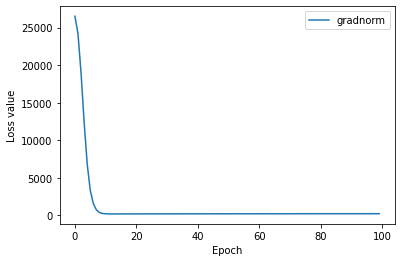

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data=training_loss)

plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.show()

In [ ]:
for i in range(len(costtr)):
  costtr[i] = costtr[i].detach().numpy()

In [ ]:
for i in range(len(cost1tr)):
  cost1tr[i] = cost1tr[i].detach().numpy()
for i in range(len(cost2tr)):
  cost2tr[i] = cost2tr[i].detach().numpy()

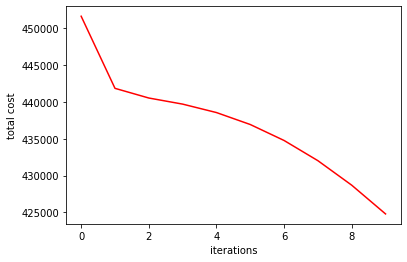

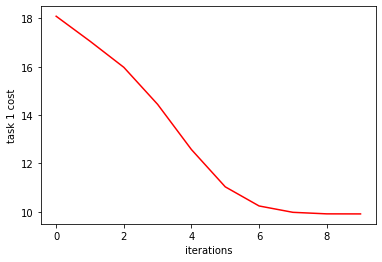

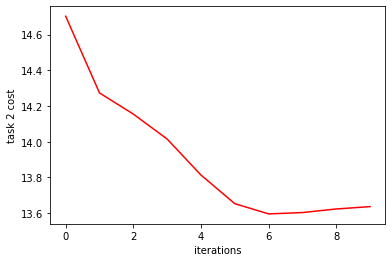

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.squeeze(costtr),'-r')
plt.ylabel('total cost')
plt.xlabel('iterations')
plt.show() 

plt.plot(np.squeeze(cost1tr),'-r')
plt.ylabel('task 1 cost')
plt.xlabel('iterations')
plt.show() 

plt.plot(np.squeeze(cost2tr),'-r')
plt.ylabel('task 2 cost')
plt.xlabel('iterations')
plt.show()

In [ ]:
def criterion(y_pred, y_true, loss_func, continuous):
  loss = 0
  if continuous == True:
    loss_value = loss_func(y_pred,y_true)
  else:
    loss_value = loss_func(y_pred,y_true.squeeze().type(torch.LongTensor))
  return loss_value

def criterion_uncertainty(y_pred, y_true, log_vars, loss_func, continuous):
  loss = 0
  precision = torch.exp(-log_vars)
  if continuous == True:
    loss_value = loss_func(y_pred,y_true)
  else:
    loss_value = loss_func(y_pred,y_true.squeeze().type(torch.LongTensor))

  loss = torch.sum(precision * loss_value + log_vars, -1)
  return loss

In [ ]:
for epoch in range(1, 10):
    train_loss = 0.0
    # train the model #
    model.train()
    for index, dataset in enumerate(dataloader):
        loss = 0
        patient_state = dataset['patient_state']
        # zero the parameter gradients
        optimizer.zero_grad()
        output=model(patient_state)
        
        for i in list(dataset.keys())[1:]:
          label = dataset[i]
          label_hat = output[i]
          #log_var = log_var_dict[i]
          if i == '血液流速' or i == '透析液流速':
            #label_hat = label_hat.squeeze()
            loss += criterion(label_hat,label,loss_func['continuous'],True)
          else:
            loss += criterion(label_hat,label,loss_func['categorical'],False)
        loss = torch.mean(loss)
        
    
        # back prop
        loss.backward() 
        # grad
        optimizer.step()
        #train_loss = train_loss + ((1 / (index + 1)) * (loss.data - train_loss))
        if index % 20 == 0:
            #loss_list1.append(loss.item())
            print('Epoch %d, Batch %d trainloss: %.6f' %
              (epoch, index + 1, loss))
    

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Batch 1 trainloss: 307314.250000
Epoch 1, Batch 21 trainloss: 357924.781250
Epoch 1, Batch 41 trainloss: 305974.187500


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 2, Batch 1 trainloss: 299210.343750
Epoch 2, Batch 21 trainloss: 344207.250000
Epoch 2, Batch 41 trainloss: 277203.375000
Epoch 3, Batch 1 trainloss: 256435.421875
Epoch 3, Batch 21 trainloss: 280513.875000
Epoch 3, Batch 41 trainloss: 184138.843750
Epoch 4, Batch 1 trainloss: 147625.968750
Epoch 4, Batch 21 trainloss: 148086.343750
Epoch 4, Batch 41 trainloss: 69899.812500
Epoch 5, Batch 1 trainloss: 46986.859375
Epoch 5, Batch 21 trainloss: 43876.976562
Epoch 5, Batch 41 trainloss: 31243.486328
Epoch 6, Batch 1 trainloss: 22147.892578
Epoch 6, Batch 21 trainloss: 17651.386719
Epoch 6, Batch 41 trainloss: 19598.716797
Epoch 7, Batch 1 trainloss: 16638.039062
Epoch 7, Batch 21 trainloss: 13505.539062
Epoch 7, Batch 41 trainloss: 15382.228516
Epoch 8, Batch 1 trainloss: 15353.116211
Epoch 8, Batch 21 trainloss: 12481.942383
Epoch 8, Batch 41 trainloss: 13386.166992
Epoch 9, Batch 1 trainloss: 14405.779297
Epoch 9, Batch 21 trainloss: 11781.993164
Epoch 9, Batch 41 trainloss: 12011

In [ ]:
loss_list1 = loss_list1[2::3]
loss_list2 = loss_list2[2::3]
training_loss = pd.DataFrame(columns=['baseline', 'uncertainty'])
training_loss['baseline'] = loss_list1
training_loss['uncertainty'] = loss_list2

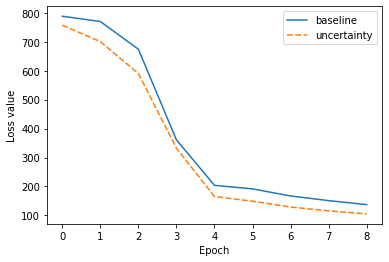

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(data=training_loss)

plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.show()

In [ ]:
print(torch.exp(log_var_dict['透析方式'])**0.5, torch.exp(log_var_dict['抗凝劑'])**0.5)

tensor([0.9751], grad_fn=<PowBackward0>) tensor([1.0539], grad_fn=<PowBackward0>)
